<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Linear-Data-(Homoscedasticity)" data-toc-modified-id="Linear-Data-(Homoscedasticity)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Linear Data (Homoscedasticity)</a></span></li><li><span><a href="#Non-Linear-Data-(Heteroscedasticity)" data-toc-modified-id="Non-Linear-Data-(Heteroscedasticity)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Non-Linear Data (Heteroscedasticity)</a></span></li></ul></li><li><span><a href="#DNN:-High-Quality-Prediction-Interval" data-toc-modified-id="DNN:-High-Quality-Prediction-Interval-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DNN: High Quality Prediction Interval</a></span></li><li><span><a href="#Quantile-regressor" data-toc-modified-id="Quantile-regressor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Quantile regressor</a></span></li><li><span><a href="#Boostrap" data-toc-modified-id="Boostrap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Boostrap</a></span></li><li><span><a href="#Compare:-Non-linear-data-(Heteroscedasticity)" data-toc-modified-id="Compare:-Non-linear-data-(Heteroscedasticity)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compare: Non-linear data (Heteroscedasticity)</a></span><ul class="toc-item"><li><span><a href="#HQ-PI" data-toc-modified-id="HQ-PI-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>HQ PI</a></span></li><li><span><a href="#Quantile-regressin" data-toc-modified-id="Quantile-regressin-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Quantile regressin</a></span></li><li><span><a href="#Bootstrap" data-toc-modified-id="Bootstrap-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Bootstrap</a></span></li><li><span><a href="#Ploting-(Show-me-dont-tell-me)" data-toc-modified-id="Ploting-(Show-me-dont-tell-me)-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Ploting (Show me dont tell me)</a></span></li></ul></li></ul></div>

# Prediction interval 

**WIP**

**TODO:**

1. Linear Data
    * Compute prediction intevals in linear data and compare with +/- sigma
    * Use the data to introduce the algorithms: DNN, Qunatile and Booststrap
    * Compare qith quantile regression, bootstrap and the true model  +/- sigma
    
2. Non Linear data  (heterosdaticity)
    * Compare results with quantile regression and boostrap 
    
* Move quantile regression to a new notebook. It is too big to be here

## Intro

In many situations only a punctual estimation is not enough for take decisions. For instance if a car dealler wants to shchedule a preemptive mantenance, a ML model that outputs that a car will present a fault in 60 days is not enough. A ML that outputs that a car will present a fault between 65 - 90 days with 99% of probability is a way better information in this situation.

In this notebook we present 3 different ways of estimate predictions intervals in machine learnings. 
1. DNN: ([High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach](https://arxiv.org/abs/1802.07167))
    * Crons:
        * Requires a lot of data to have good estimation (MDNN normally requires)
        * Very sensitive to initialization. Problem when initial coverage is zero 

1. Quantile regression [Quantile regression ](https://www.jstor.org/stable/1913643) and [Dan Saattrup Nielsen](https://saattrupdan.github.io/2020-03-09-quantile-regression/)
    * Crons:
        * Requires a lot of data to have good estimation

1. Boostrap for computing prediciton intervals [Dan Saattrup Nielsen](https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/)
    * Crons: Computational expensive. Not practical for large models or big data
    * Pros: 
        * Simple, and easy to understand and explain
        * Good for small data size or linear regression models 

**TODO**: Add advantage and disadvantage of each approache HERE

We adopt a pragmatic approach in how to use the models and highlight the main concepts of each methodology. The details on how it works and the models implementations is outside of the scope of this notebook. Please rely on the references and academic article from that. 

The first concept we want to dicuss, is the concept of prediction intervals and confidence intervals. The total uncertainty in machine learning is given by:

$
\sigma_y^2 = \sigma_{model}^2 + \sigma_{noise}^2
$

where $\sigma_{model}^2$ can be decomposed in the bias and variance error.

$\sigma_{noise}^2$ is the **irreductivel error**

Below is the main differences:

* Confidence Intervals in inference (https://en.wikipedia.org/wiki/Prediction_interval)
    * quantify the uncertainty in a population parameter such as the mean
    * Take into account data dispersion in a sample of a population
    * Confience intervals in the context of regression is an estimation of $\sigma_{model}^2$ 
    
* ML Confidence Intervals ([High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach](https://arxiv.org/abs/1802.07167)):
    * Uncertainty in models  ($\sigma_{model}^2$)
    * Usually measure uncertainty in determination of the statistics of a population like the mean.

> PS: code (python) and discusison to help with plot ci and pi together:
> * https://towardsdatascience.com/how-confidence-and-prediction-intervals-work-4592019576d8
> * https://towardsdatascience.com/confidence-intervals-vs-prediction-intervals-7b296ae58745

* ML Prediciton Intervals
    * quantify uncertainty of model and noise $\sigma_{model}^2 + \sigma_{noise}^2$
    * Prediction intervals describe the uncertainty for a single specific outcome not observable before (**prediction**)
    * Prediction intervals usually is not constant accross $X$ and certainly $PI > CI$


**TODO**: explain what you are going to talk in the nb
1. Focus more in HQ PI article 
1. Brief intro to quantile regression and bootstrap
1. Compare results for Linear Data (Homodasticity) and non-linear data (Heterodasticity)

This notebook is split in 2 sections 1. Linear data. A short section where we compare the applicaiton of the 3 approaches in linear data and; 2. Heteroscedasticity data where we compare the first 2 approaches in a more complex data, since Boostrap  cannot be handle [Heteroscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity) ([Dan Saattrup Nielsen](https://saattrupdan.github.io/2020-03-09-quantile-regression/))

References:
* https://en.wikipedia.org/wiki/Prediction_interval
* https://en.wikipedia.org/wiki/Confidence_and_prediction_bands
* https://machinelearningmastery.com/prediction-intervals-for-machine-learning/
* Blog of the dats scientist: [Dan Saattrup Nielsen](https://saattrupdan.github.io/)  **<== This one is very good**
    * https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/
    * https://saattrupdan.github.io/2020-03-09-quantile-regression/

In [1]:
import IPython
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
# import keras
# from keras import backend as K

print(tf.__version__)

2023-04-08 21:28:22.232994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 21:28:22.436278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-08 21:28:22.436312: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-08 21:28:22.467780: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-08 21:28:23.609338: W tensorflow/stream_executor/platform/de

2.10.0


## Data

* Linear data for simplicity and comapre with linera reression
* Non linear qith hetredosticity data to compare all approaches

### Linear Data (Homoscedasticity)

2 std: 0.50


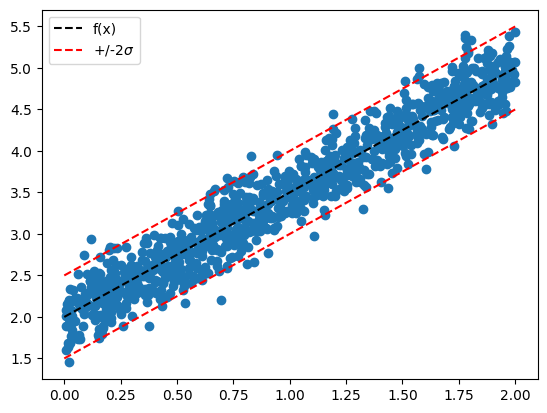

In [3]:
linear_params = {'a': 1.5, 'b': 2.0, 'sigma': 0.25}

def make_linear_data(n_samples, linear_params):

    X = np.random.uniform(low=0.,high=2.,size=(n_samples,1))

    _sigma = linear_params.get('sigma',None)
    
    noise = np.random.normal(loc=0.,scale=_sigma,size=(n_samples,1))

    a = linear_params.get('a',None)
    b = linear_params.get('b',None)
    f_x = a*X + b
    
    y =  f_x + noise

    #y = y.reshape([-1,1])/5.  # Is this important? Divide by 5 ? Why did he do it?
    y = y.reshape([-1,1])  # Is this important? Divide by 5 ? Why did he do it?

    X_train = X.reshape(-1)
    y_train = y.reshape(-1)

    X_train.shape
    y_train.shape

    yy_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted

    return X_train, y_train, yy_train
   
# create some data
n_samples = 1000
X_train, y_train, _ = make_linear_data(n_samples,linear_params)  
    
plt.scatter(X_train,y_train)

x_grid = np.linspace(0.0,2,100) # for evaluation plots
a = linear_params.get('a',None)
b = linear_params.get('b',None)
_sigma = linear_params.get('sigma',None)

f_x = a* x_grid + b
_delta = 2.0*_sigma  # 2 sigmas

print(f"2 std: {_delta:.2f}")

plt.plot(x_grid, f_x, 'k--',label='f(x)'); # regression line
plt.plot(x_grid, f_x + _delta, 'r--', label='+/-2$\sigma$'); # upper boundary prediction
plt.plot(x_grid, f_x - _delta, 'r--'); # lower boundary prediction
plt.legend();

### Non-Linear Data (Heteroscedasticity)

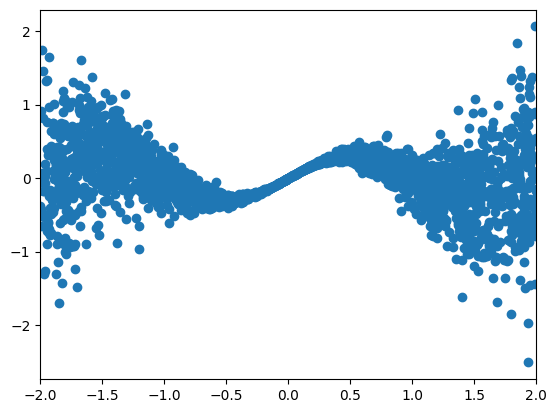

In [4]:
def make_non_linear_data(n_samples):

    X = np.random.uniform(low=-2.,high=2.,size=(n_samples,1))
    y = 1.5*np.sin(np.pi*X[:,0]) + np.random.normal(loc=0.,scale=1.*np.power(X[:,0],2))

    # normalization
    y = y.reshape([-1,1])/5.

    X_train = X.reshape(-1)
    y_train = y.reshape(-1)

    yy_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted

    return X_train, y_train, yy_train
    
# create some data
n_samples = 2500

X_train, y_train, yy_train = make_non_linear_data(n_samples)

x_grid = np.linspace(-2,2,100) # for evaluation plots

y_train.shape
yy_train.shape

# TODO: Add f(x) +/- 2 sigma
#   f(x) = 1.5*np.sin(np.pi*X[:,0])
#   sigma => see scale in the code np.random.normal(loc=0.,scale=1.*np.power(X[:,0],2))
plt.scatter(X_train,y_train);
plt.xlim(-2,2);
plt.show();

## DNN: High Quality Prediction Interval

refs:

* https://github.com/TeaPearce/Deep_Learning_Prediction_Intervals
* High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach
    * https://arxiv.org/pdf/1802.07167.pdf

The paper "High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach" introduces a loss function that is distribution-free (no distribution assumption) and can be used with any deep learning model. The paper defines a High Quality (HQ) prediciton intervals as:

1. Should be narrow as posisible and capture the data uncertainty. The should rely on the narrow interval
1. It has highest as possible interval coverage

A new loss functions is proposed with 2 terms to address the problem of find a high quality interval. The first term is related to the interval size (MPIW_c) and the second with interval coverage. Both terms in the loss are minimized: MPIW_c and coverage related term:

* $Loss_{QD} = MPIW_c + f(PICP_S)$

The first term $MPIW_c$ measures the average width of the intervals across all data. It is defined as:

$
MPIW = \frac{1}{n} \sum_{i=1}^n{\hat{y}_{Ui} − \hat{y}_{L_i}}
$

The interval coverage (PICP) is maximized by minimizing the second term $f$.This term encourages the model to produce intervals that contain the true target value with a high probability. 

$
PICP = \frac{c}{n}
$

The quality-driven loss function has the characteristics:

1. Minimizes $MPIW_c$ with the contraint: $PICP < (1 - \alpha) \equiv (PCIP - (1 -\alpha)) > 0$

This inequality defines the minimum proportion of data points that should be covered by the prediction intervals. $\alpha$ is the significance level of the prediction intervals (i.e., the probability of the target value falling outside the interval). The right-hand side represents the excess coverage beyond the minimum requirement. The excess coverage is penalized in the loss function with the term $\lambda \frac{n}{\alpha (1 - \alpha)}max(0, (1-\alpha) - PCIP)^2$, where $\lambda$ is a hyperparameter that controls the strength of the penalty and $n$ is the number of data points.

1. The loss assume large $n$ and utilize the approximation $B(n, (1- \alpha)) \approx N(n(1-\alpha), n\alpha(1 - \alpha))$.
    * requies batch size greather than 50

The loss is defined as:

* $Loss = MPIW_{c} + \lambda \frac{n}{\alpha (1 - \alpha)}max(0, (1-\alpha) - PCIP)^2$ 
    * extra penality $\lambda \frac{n}{\alpha (1 - \alpha)}max(0, (1-\alpha) - PCIP)^2$ when $y$ is not in the interval


In [31]:
# NOTEs: See this nb: (<== BETTER RESULTS. USE THIS PARAMETERS and DNN INSTEAD)
# prediction_intervals/archived/2022-07-20/2022-06-24-lhof-Understand_paper_QD_AsFastAsPoss_notebook.ipynb 

#hyperparameters
# lambda_ = 0.01 # lambda in loss fn
# alpha_ = 0.10  # capturing (1-alpha)% of samples
# soften_ = 160.
# n_ = 500 # batch size
# bias: [3.0,1.0] last layer

lambda_ = 0.01 # lambda in loss fn
alpha_ = 0.05 # capturing (1-alpha)% of samples
soften_ = 160.
n_ = 500 # batch size


C = lambda_*n_/(alpha_*(1.0 - alpha_))

print(f"params: lambda: {lambda_} n_: {n_}; alpha: {alpha_} => C:{C:.2f}")

# define loss fn
#def qd_objective(y_true, y_pred, n_=100, lambda_=0.01, alpha_ = 0.05, soften_ = 160):
def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''

    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)

    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)

    return Loss_S

def picp_metric(y_true, y_pred):

    y_true = y_true[:,0]
    
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    PICP_S = tf.reduce_mean(K_S)
    
    return PICP_S

def mpiw_metric(y_true, y_pred):
    
    y_true = y_true[:,0]
    
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)

    return MPIW_c

def coverage_term_metric(y_true, y_pred):
    
    y_true = y_true[:,0]

    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    PICP_S = tf.reduce_mean(K_S)

    coverage_term = lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)
    
    return coverage_term

params: lambda: 0.01 n_: 500; alpha: 0.05 => C:105.26


In [32]:
# set up model
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))

model.add(Dense(2, activation='linear',
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2), 
                bias_initializer=tf.keras.initializers.Constant(value=[3.0,1.00]))) # important to init biases to start!

# compile
opt = tf.keras.optimizers.Adam(lr=0.02, decay=0.005)
model.compile(loss=qd_objective, optimizer=opt, metrics=[mpiw_metric,coverage_term_metric,picp_metric])

/home/leandroohf/.venvs/ml-leandro/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
n_samples = 15000
X_train, y_train, yy_train = make_linear_data(n_samples,linear_params)

Inital metrics: mpiw: 2.28; coverage term: 63.15; picp: 35.0%


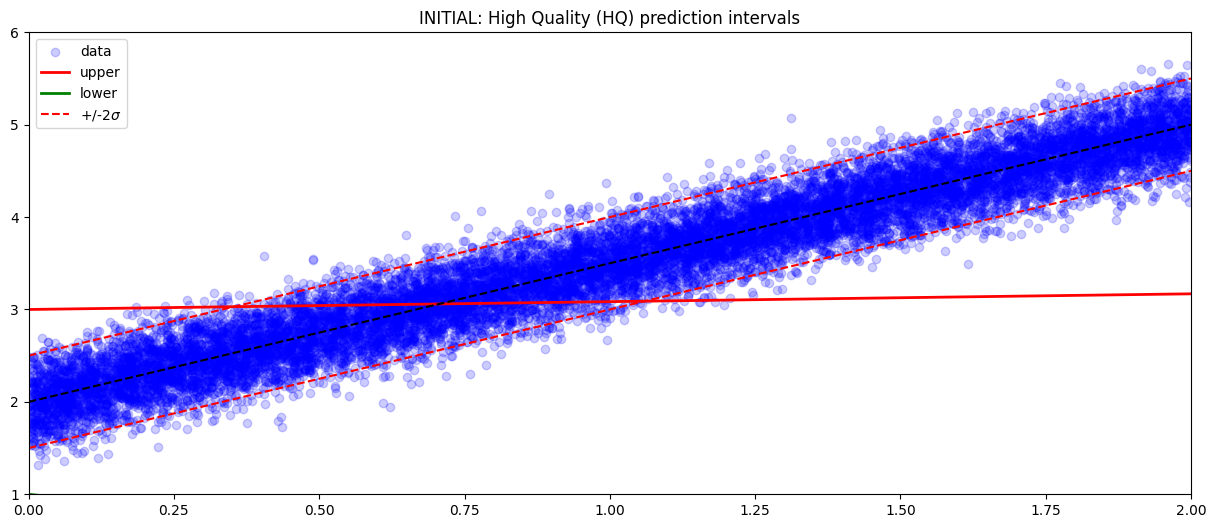

In [34]:
grid_size = 100

x_grid = np.linspace(0.0,2.0,grid_size) # for evaluation plots

a = linear_params.get('a',None)
b = linear_params.get('b',None)
_sigma = linear_params.get('sigma',None)

f_x = a* x_grid + b
_delta = 2.0*_sigma  # 2 sigmas

y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]#*norm_factor
y_l_pred = y_pred[:,1]#*norm_factor

# Inital metrics
y_pred0 = model.predict(X_train, verbose=0)

mpiw0 = mpiw_metric(yy_train, y_pred0)
picp0 = picp_metric(yy_train, y_pred0)
cover0 = coverage_term_metric(yy_train, y_pred0)

print(f"Inital metrics: mpiw: {mpiw0:.2f}; coverage term: {cover0:.2f}; picp: {picp0:.1%}")

_ = plt.figure(figsize=[15, 6])

_ = plt.scatter(X_train, y_train, label='data', alpha=.2, color='blue')

_ = plt.plot(x_grid, y_u_pred, color='r',label='upper',linewidth=2) # upper boundary prediction
_ = plt.plot(x_grid, y_l_pred, color='g',label='lower',linewidth=2) # lower boundary prediction

_ = plt.plot(x_grid, f_x + _delta, 'r--', label='+/-2$\sigma$'); # upper boundary prediction
_ = plt.plot(x_grid, f_x, 'k--'); # f(x)
_ = plt.plot(x_grid, f_x - _delta, 'r--'); # lower boundary prediction

_ = plt.title('INITIAL: High Quality (HQ) prediction intervals')
_ = plt.xlim(0,2);
_ = plt.ylim(1.0,6.0);
_ = plt.legend();
_ = plt.show()

In [35]:
%%time

result = model.fit(X_train, yy_train, epochs=100, batch_size=n_, verbose=1,  validation_split=0.)

Epoch 1/100
30/30 [==============================] - 1s 2ms/step - loss: 9.2485 - mpiw_metric: 3.6454 - coverage_term_metric: 5.6031 - picp_metric: 0.9330
Epoch 2/100
30/30 [==============================] - 0s 1ms/step - loss: 4.1565 - mpiw_metric: 4.1565 - coverage_term_metric: 0.0000e+00 - picp_metric: 1.0000
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 3.0782 - mpiw_metric: 3.0782 - coverage_term_metric: 0.0000e+00 - picp_metric: 0.9964
Epoch 4/100
30/30 [==============================] - 0s 1ms/step - loss: 2.7912 - mpiw_metric: 2.6956 - coverage_term_metric: 0.0956 - picp_metric: 0.9909
Epoch 5/100
30/30 [==============================] - 0s 1ms/step - loss: 2.2811 - mpiw_metric: 2.2811 - coverage_term_metric: 0.0000e+00 - picp_metric: 0.9974
Epoch 6/100
30/30 [==============================] - 0s 1ms/step - loss: 1.8343 - mpiw_metric: 1.8259 - coverage_term_metric: 0.0083 - picp_metric: 0.9877
Epoch 7/100
30/30 [==============================] - 0s 1m

30/30 [==============================] - 0s 1ms/step - loss: 1.1202 - mpiw_metric: 1.1191 - coverage_term_metric: 0.0011 - picp_metric: 0.9685
Epoch 54/100
30/30 [==============================] - 0s 1ms/step - loss: 1.1364 - mpiw_metric: 1.1344 - coverage_term_metric: 0.0020 - picp_metric: 0.9734
Epoch 55/100
30/30 [==============================] - 0s 1ms/step - loss: 1.1997 - mpiw_metric: 1.1707 - coverage_term_metric: 0.0290 - picp_metric: 0.9635
Epoch 56/100
30/30 [==============================] - 0s 1ms/step - loss: 1.3902 - mpiw_metric: 1.3902 - coverage_term_metric: 0.0000e+00 - picp_metric: 0.9903
Epoch 57/100
30/30 [==============================] - 0s 1ms/step - loss: 1.2226 - mpiw_metric: 1.2226 - coverage_term_metric: 0.0000e+00 - picp_metric: 0.9795
Epoch 58/100
30/30 [==============================] - 0s 1ms/step - loss: 1.1152 - mpiw_metric: 1.1080 - coverage_term_metric: 0.0071 - picp_metric: 0.9670
Epoch 59/100
30/30 [==============================] - 0s 1ms/step - l

In [36]:
def graph_pi_report(result):
    
    result_loss =np.array(result.history['loss']).reshape(-1)

    result_loss.shape

    print(f"loss last 5 values: {result_loss[-6:-1]}")
    print(f"mean loss last 5 values: {np.mean(result_loss[-6:-1])}")

    val_loss = result.history.get('val_loss')
    
    x = range(result_loss.shape[0])
    plt.plot(x, result_loss, label='train')
    
    if val_loss:
        plt.plot(x, val_loss, label='val')
    
    plt.title('Loss')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim(0,6)
    plt.show()
 
    # view training
    result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
    result_coverage_term = np.array(result.history['coverage_term_metric']).reshape(-1)

    print(f"Init guess => mpiw: {result_mpiw[0]}; coverage_term: {result_coverage_term[0]}")
    print(f"Last values => mpiw: {result_mpiw[-1]}; coverage_term: {result_coverage_term[-1]}")

    fig, ax1 = plt.subplots()
    x = range(result_mpiw.shape[0])

    ax2 = ax1.twinx()
    ax1.plot(x, result_mpiw, label='mpiw_metric', color='b')
    ax2.plot(x, result_coverage_term,label='coverage_term_metric',color='g')

    # ax1.set_xlabel('X data')
    ax1.set_ylabel('mpiw_metric', color='b')
    ax2.set_ylabel('coverage_term_metric', color='g')

    #plt.legend()
    plt.show()

    # view training
    result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
    result_picp = np.array(result.history['picp_metric']).reshape(-1)

    print(f"Init guess => mpiw: {result_mpiw[0]}; picp: {result_picp[0]}")
    print(f"Last values => mpiw: {result_mpiw[-1]}; picp: {result_picp[-1]}")

    fig, ax1 = plt.subplots()

    x = range(result_mpiw.shape[0])

    ax2 = ax1.twinx()
    ax1.plot(x, result_mpiw, label='mpiw_metric', color='b')
    ax2.plot(x, result_picp,label='picp_metric',color='g')

    # ax1.set_xlabel('X data')
    ax1.set_ylabel('mpiw_metric', color='b')
    ax2.set_ylabel('picp_metric', color='g')

    plt.show()
    
    val_picp = result.history.get('val_picp_metric')
    train_picp = result.history['picp_metric']
    
    if val_picp:
        
        plt.plot(x, train_picp, label='train')
        plt.plot(x, val_picp, label='val')
        plt.title('picp')
        
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.show()

loss last 5 values: [1.18904448 1.12397659 1.12819791 1.12407267 1.13266468]
mean loss last 5 values: 1.1395912647247315


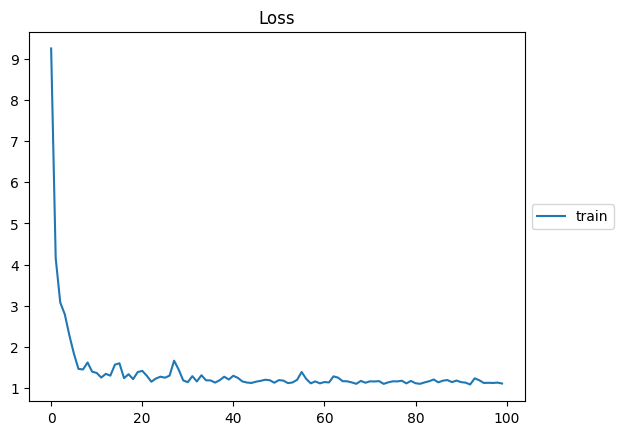

Init guess => mpiw: 3.6454081535339355; coverage_term: 5.60313081741333
Last values => mpiw: 1.1103335618972778; coverage_term: 0.0


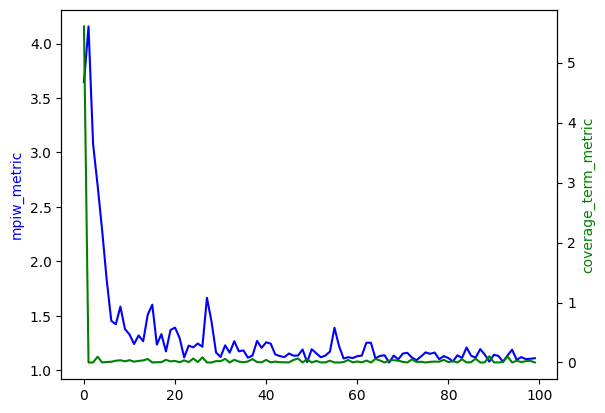

Init guess => mpiw: 3.6454081535339355; picp: 0.9330149292945862
Last values => mpiw: 1.1103335618972778; picp: 0.9692158102989197


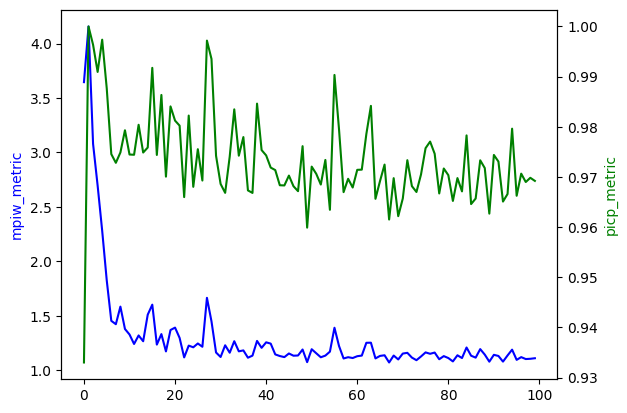

In [37]:
graph_pi_report(result)

Final metrics: mpiw: 1.05; coverage term: 0.00; picp: 95.8%


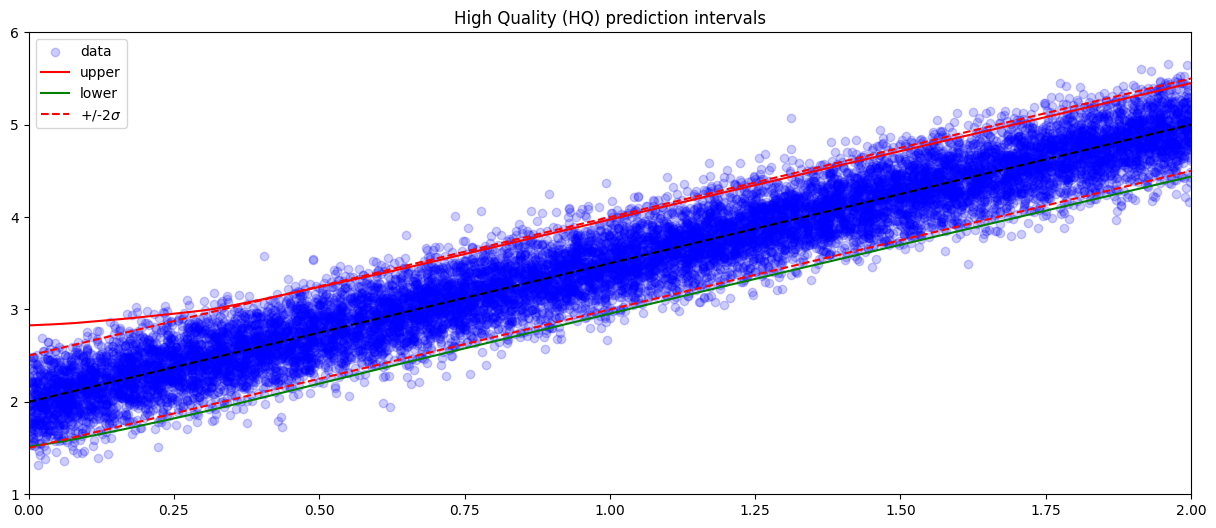

In [38]:
grid_size = 100

x_grid = np.linspace(0.0,2.0,grid_size) # for evaluation plots

a = linear_params.get('a',None)
b = linear_params.get('b',None)
_sigma = linear_params.get('sigma',None)

f_x = a* x_grid + b
_delta = 2.0*_sigma  # 2 sigmas

y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]#*norm_factor
y_l_pred = y_pred[:,1]#*norm_factor

# Final metrics
y_predf = model.predict(X_train, verbose=0)

mpiwf = mpiw_metric(yy_train, y_predf)
picpf = picp_metric(yy_train, y_predf)
coverf = coverage_term_metric(yy_train, y_predf)

print(f"Final metrics: mpiw: {mpiwf:.2f}; coverage term: {coverf:.2f}; picp: {picpf:.1%}")

_ = plt.figure(figsize=[15, 6])

_ = plt.scatter(X_train, y_train, label='data', alpha=.2, color='blue')

_ = plt.plot(x_grid, y_u_pred, color='r',label='upper') # upper  prediction interval
_ = plt.plot(x_grid, y_l_pred, color='g',label='lower') # lower prediction interval

_ = plt.plot(x_grid, f_x + _delta, 'r--', label='+/-2$\sigma$'); # upper boundary prediction
_ = plt.plot(x_grid, f_x, 'k--'); # f(x)
_ = plt.plot(x_grid, f_x - _delta, 'r--'); # lower boundary prediction

_ = plt.title('High Quality (HQ) prediction intervals')
_ = plt.xlim(0,2);
_ = plt.ylim(1.0,6.0);
_ = plt.legend();
_ = plt.show()

**TODO**;

* Show in the graph: $\alpha = \{0.05, 0.32\}$. I belive enphize the importance of $\alpha$ the significance level
    * add $+/- \sigma$ and $+/-2\sigma$

## Quantile regressor 

**TODO**:

1. Break this nb: Create a new intro_quantile_regression.ipynb 
1. Cite intro_quantile_regression.ipynb here 
1. small description

Disanbiquation:

Linear Quantile Regressor (Statistics)
* alternative to linear regression when there is Heteroscedasticity. Can be seen as generalization of Lnear regression
assumptions (https://stats.stackexchange.com/questions/320991/what-are-the-assumptions-for-applying-a-quantile-regression-model)
* no assumtions about the target distributions (**The main motivation**)
* linearity of the coeficients (LighGBM does not have this assumtions)
* independence of observations
* very large sample size, as quantile regression is not very efficient
* y is "very" continuos


LightGBM quantile regressor (Machine Learning)

* Quantile is used to predict intervals of target variable
* The main difference related to generic regression is the loss function:
pinball loss: pos slope is  and negative slope is  (https://www.lokad.com/pinball-loss-function-definition#:~:text=The%20pinball%20loss%20function%20is,forecast%20is%20a%20subtle%20problem.)
 * $\tau = 0.5$ the loss is symetric
 * $\tau < 0.5$ penalizes more the positive error (see inclimation of the loss)
 * $\tau > 0.5$ penalizes more the negative side
* based on R doc: https://astrostatistics.psu.edu/datasets/R/html/quantreg/html/rq.html
    * $\tau$ is the quantile to be predict, so in python is 
* LIGHGBM $\alpha$ is the quantile we want to predict

In [13]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

grid_size = 150

X_train = X_train.reshape(-1, 1)
X_train.shape

params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 2,
    'num_leaves': 10,
    'learning_rate': 0.1,
    'n_estimators': 150,
    'boosting_type': 'gbdt'
}

y_preds = np.zeros((grid_size, 3))
quantiles = [.05, .5, .95]

x_grid = np.linspace(0.0,2.0,grid_size).reshape(-1, 1)

y_preds.shape
x_grid.shape

for i in range(len(quantiles)):
    print('prediction of quantile', quantiles[i])
    lgb = LGBMRegressor(alpha=quantiles[i], **params)
    model = lgb.fit(X_train, y_train)
    y_preds[:, i] = model.predict(x_grid)

(15000, 1)

(150, 3)

(150, 1)

prediction of quantile 0.05
prediction of quantile 0.5
prediction of quantile 0.95


<Figure size 1500x600 with 0 Axes>

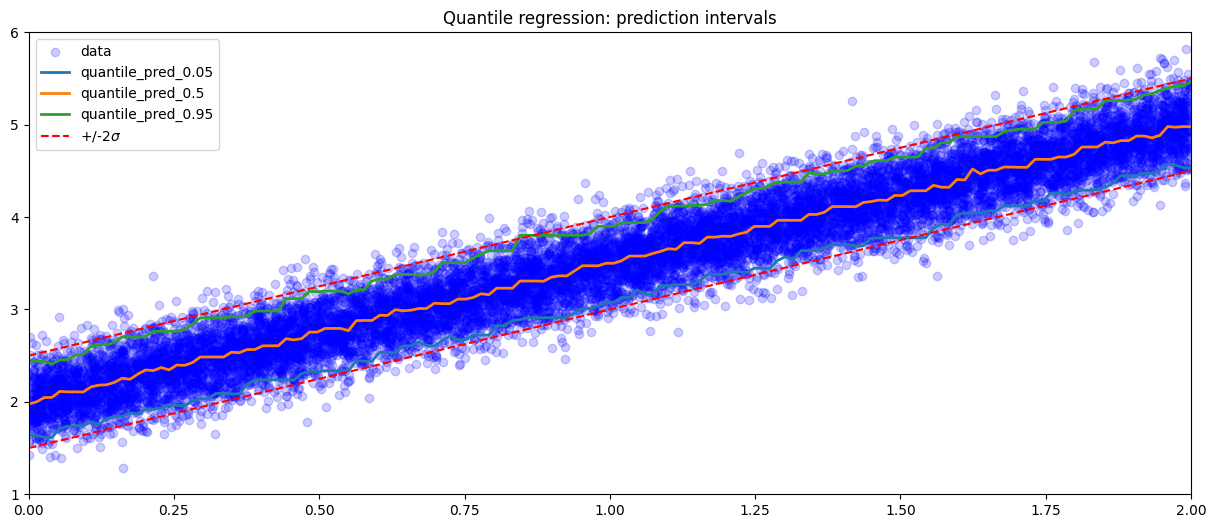

In [14]:
plt.figure(figsize=[15, 6])

a = linear_params.get('a',None)
b = linear_params.get('b',None)
_sigma = linear_params.get('sigma',None)

f_x = a* x_grid + b
_delta = 2.0*_sigma  # 2 sigmas

plt.scatter(X_train, y_train, label='data', alpha=.2, color='blue')
for i in range(len(quantiles)):
    _ = plt.plot(x_grid, y_preds[:, i], label='quantile_pred_{}'.format(quantiles[i]),linewidth=2)
    
_ = plt.plot(x_grid, f_x + _delta, 'r--', label='+/-2$\sigma$'); # upper boundary prediction
_ = plt.plot(x_grid, f_x - _delta, 'r--'); # lower boundary prediction

_ = plt.title('Quantile regression: prediction intervals')

_ = plt.xlim(0.0,2.0)
_ = plt.ylim(1.0,6.0)
_ = plt.legend();
_ = plt.show()

## Boostrap 

refs:
* https://www.saattrupdan.com/posts/2021-04-04-doubt
* https://www.saattrupdan.com/2020-03-01-bootstrap-prediction

Bootstrapping is a resampling technique that involves generating new datasets by sampling with replacement from the original dataset. It can be used to estimate prediction intervals by repeatedly fitting the model to bootstrap samples and computing the desired quantiles of the resulting distribution of predictions.

* Pros (statisics)
    * No assuption of data distribution. Linear regression assumes normal distributions and **Homoscedasticity** fr instance. So, can be more reliable. 

* Crons:
    * computationally expensive
    * the PI can be too narrow or too wide many times
    * the bootstrap resampling method may produce biased prediction intervals because it assumes that the errors are homoscedastic
        *  In such cases, it may be necessary to use a modified bootstrap method that takes into account the heteroscedasticity of the errors. (More complex. Not in this nb) 
refs:
* https://medium.com/@joetrankang/i-used-data-science-and-bootstrap-to-determine-the-optimal-housing-price-daddeefaa8eb
* Look gitlab code and org files for R code for boostrap 


In [15]:
from doubt.datasets import PowerPlant
from sklearn.linear_model import LinearRegression
from doubt import Boot

/home/leandroohf/.venvs/ml-leandro/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
%%time

model = Boot(LinearRegression())
model.fit(X_train.reshape(-1, 1), y_train)

_median, _pi = model.predict(x_grid, uncertainty=0.05)
_lower, _upper = _pi[:,0], _pi[:,1]

CPU times: user 25.9 s, sys: 1.75 s, total: 27.6 s
Wall time: 27.7 s


In [17]:
_pi.shape

_median.shape
_lower.shape
_upper.shape

(150, 2)

(150,)

(150,)

(150,)

<Figure size 1500x600 with 0 Axes>

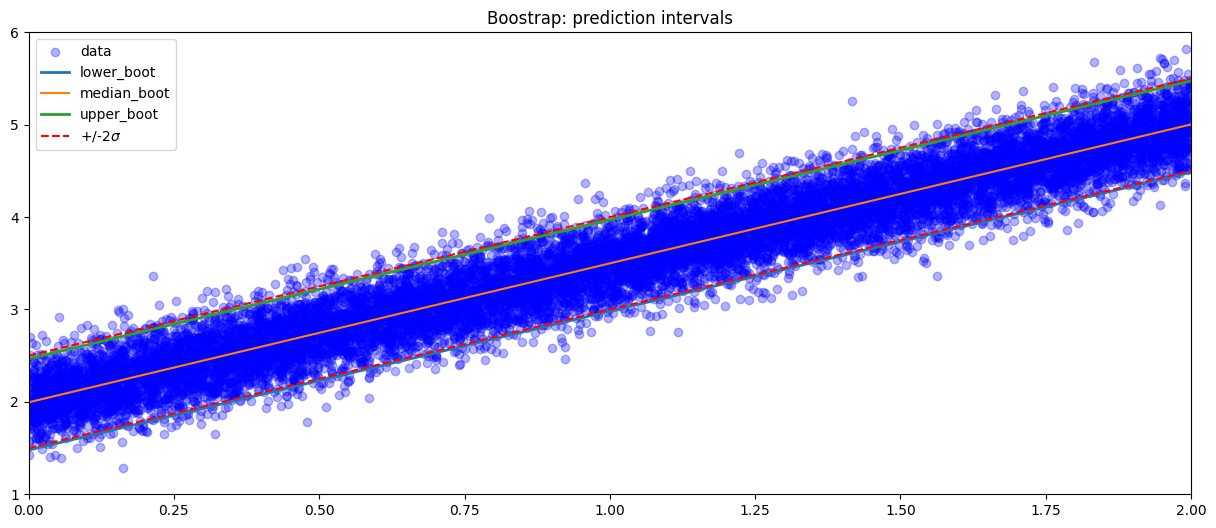

In [18]:
plt.figure(figsize=[15, 6])

a = linear_params.get('a',None)
b = linear_params.get('b',None)
_sigma = linear_params.get('sigma',None)

f_x = a* x_grid + b
_delta = 2.0*_sigma  # 2 sigmas

_ = plt.scatter(X_train, y_train, label='data', alpha=.3, color='blue')

_ = plt.plot(x_grid,_lower , label='lower_boot',linewidth=2)
_ = plt.plot(x_grid, _median, label='median_boot')
_ = plt.plot(x_grid, _upper, label='upper_boot', linewidth=2)

_ = plt.plot(x_grid, f_x + _delta, 'r--', label='+/-2$\sigma$'); # upper boundary prediction
_ = plt.plot(x_grid, f_x - _delta, 'r--'); # lower boundary prediction

_ = plt.title('Boostrap: prediction intervals')

_ = plt.xlim(0.0,2.0)
_ = plt.ylim(1.0,6.0)
_ = plt.legend();
_ = plt.show()

**TODO**:
 
* test doubt package with linear true model but heterosdacity error distribution. I want to make sure it returns PI that adjust the size of the variance of the error at X0. 


## Compare: Non-linear data (Heteroscedasticity)

In [19]:
# create some data
n_samples = 15000

X_train, y_train, yy_train = make_non_linear_data(n_samples)

grid_size = 150
x_grid = np.linspace(-2.0,2.0,grid_size) # for evaluation plots

### HQ PI

In [20]:
# NOTEs: See this nb: (<== BETTER RESULTS. USE THIS PARAMETERS and DNN INSTEAD)
# prediction_intervals/archived/2022-07-20/2022-06-24-lhof-Understand_paper_QD_AsFastAsPoss_notebook.ipynb 

#hyperparameters
# lambda_ = 0.01 # lambda in loss fn
# alpha_ = 0.10  # capturing (1-alpha)% of samples
# soften_ = 160.
# n_ = 500 # batch size
# bias: [3.0,1.0] last layer

lambda_ = 0.01 # lambda in loss fn
alpha_ = 0.05 # capturing (1-alpha)% of samples
soften_ = 250.
n_ = 200 # batch size


C = lambda_*n_/(alpha_*(1.0 - alpha_))

print(f"params: lambda: {lambda_} n_: {n_}; alpha: {alpha_} => C:{C:.2f}")

# define loss fn
#def qd_objective(y_true, y_pred, n_=100, lambda_=0.01, alpha_ = 0.05, soften_ = 160):
def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''

    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)

    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)

    return Loss_S

def picp_metric(y_true, y_pred):

    y_true = y_true[:,0]
    
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    PICP_S = tf.reduce_mean(K_S)
    
    return PICP_S

def mpiw_metric(y_true, y_pred):
    
    y_true = y_true[:,0]
    
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)

    return MPIW_c

def coverage_term_metric(y_true, y_pred):
    
    y_true = y_true[:,0]

    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    PICP_S = tf.reduce_mean(K_S)

    coverage_term = lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)
    
    return coverage_term

params: lambda: 0.01 n_: 200; alpha: 0.05 => C:42.11


In [21]:
# set up model
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))


model.add(Dense(2, activation='linear',
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3), 
                bias_initializer=tf.keras.initializers.Constant(value=[3.,-3.]))) # important to init biases to start!

# compile
opt = tf.keras.optimizers.Adam(lr=0.02, decay=0.01)
model.compile(loss=qd_objective, optimizer=opt, metrics=[mpiw_metric,coverage_term_metric,picp_metric])

/home/leandroohf/.venvs/ml-leandro/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
%%time

result = model.fit(X_train, yy_train, epochs=600, batch_size=n_, verbose=0,  validation_split=0.)

CPU times: user 51.4 s, sys: 36 s, total: 1min 27s
Wall time: 39 s


loss last 5 values: [1.09895921 1.11024976 1.08099365 1.0863235  1.08212554]
mean loss last 5 values: 1.0917303323745728


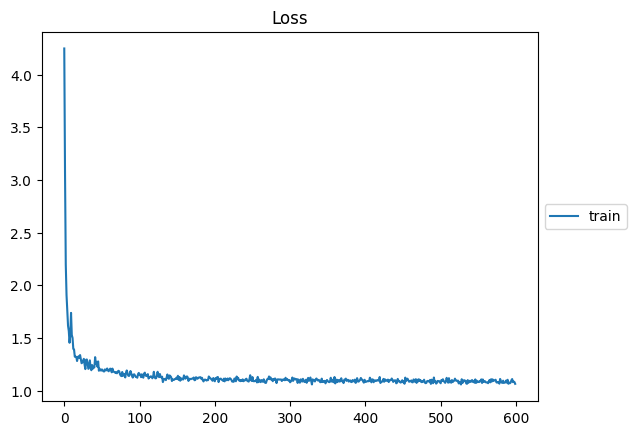

Init guess => mpiw: 3.846369743347168; coverage_term: 0.40180185437202454
Last values => mpiw: 1.0447883605957031; coverage_term: 0.020240414887666702


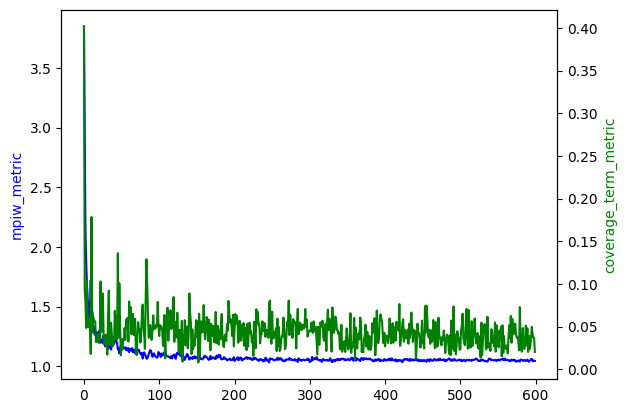

Init guess => mpiw: 3.846369743347168; picp: 0.9631568193435669
Last values => mpiw: 1.0447883605957031; picp: 0.9643278121948242


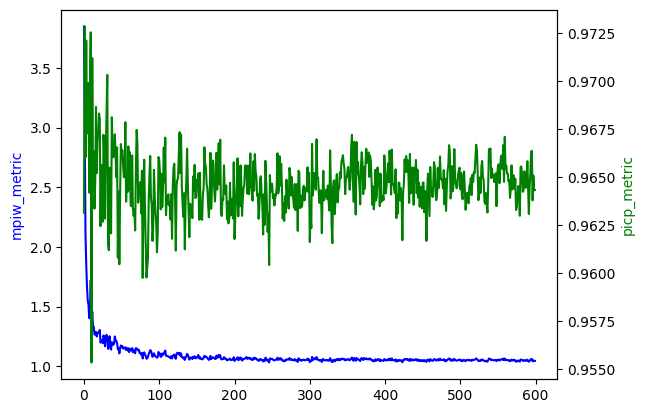

In [23]:
graph_pi_report(result)

In [24]:
y_pred = model.predict(x_grid, verbose=0)

upper_hq_pred = y_pred[:,0]
lower_hq_pred = y_pred[:,1]

### Quantile regressin

In [27]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 2,
    'num_leaves': 10,
    'learning_rate': 0.1,
    'n_estimators': 150,
    'boosting_type': 'gbdt'
}

quantile_preds = np.zeros((grid_size, 2))
quantiles = [.05, .95]

#x_grid = np.linspace(0.0,2.0,grid_size).reshape(-1, 1)

# y_preds.shape
# x_grid.shape

for i in range(len(quantiles)):
    print('prediction of quantile', quantiles[i])
    lgb = LGBMRegressor(alpha=quantiles[i], **params)
    model = lgb.fit(X_train.reshape(-1, 1), y_train)
    quantile_preds[:, i] = model.predict(x_grid.reshape(-1, 1))
    
    
lower_qr_pred = quantile_preds[:, 0]
upper_qr_pred = quantile_preds[:, 1]

prediction of quantile 0.05
prediction of quantile 0.95


### Bootstrap

In [25]:
%%time
import lightgbm as lgb

model = Boot(lgb.LGBMRegressor())
model.fit(X_train.reshape(-1, 1), y_train)

pred_boot, _pi = model.predict(x_grid.reshape(-1, 1), uncertainty=0.05)
lower_boot_pred, upper_boot_pred = _pi[:,0], _pi[:,1]

CPU times: user 35 s, sys: 188 ms, total: 35.1 s
Wall time: 31.7 s


### Ploting (Show me dont tell me)

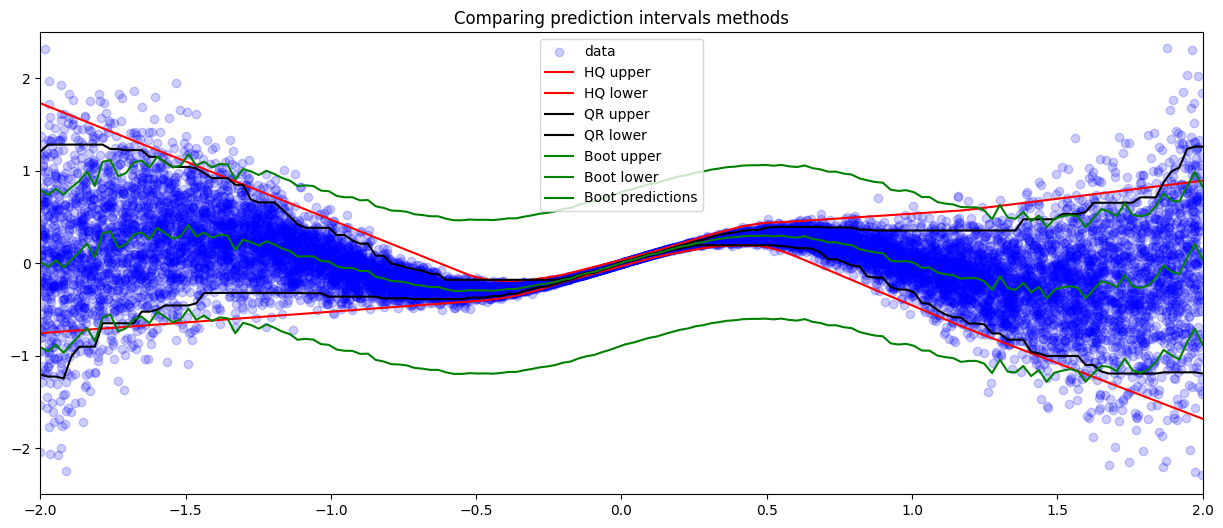

In [30]:
_ = plt.figure(figsize=[15, 6])

_ = plt.scatter(X_train, y_train, label='data', alpha=.2, color='blue')

# HQ PI 
_ = plt.plot(x_grid, upper_hq_pred, color='r',label='HQ upper') # upper boundary prediction
_ = plt.plot(x_grid, lower_hq_pred, color='r',label='HQ lower') # lower boundary prediction

# Quantile
_ = plt.plot(x_grid, upper_qr_pred, color='k',label='QR upper') # upper boundary prediction
_ = plt.plot(x_grid, lower_qr_pred, color='k',label='QR lower') # lower boundary prediction

# Bootstrap
_ = plt.plot(x_grid, upper_boot_pred, color='g',label='Boot upper') # upper boundary prediction
_ = plt.plot(x_grid, lower_boot_pred, color='g',label='Boot lower') # lower boundary prediction
_ = plt.plot(x_grid, pred_boot, color='g',label='Boot predictions') # lower boundary prediction


_ = plt.title('Comparing prediction intervals methods')
_ = plt.xlim(-2,2);
_ = plt.ylim(-2.5,2.5);
_ = plt.legend();
_ = plt.show()